In [1]:
import nbsetup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
def df_single(filename, labels, header):
    with open(filename, "r") as f:
        data = []
        for line in f.readlines()[header:]:
            row = []
            for item in line.split():
                try:
                    row.append(float(item))
                except:
                    row.append(str(item))
            data.append(row)
    return pd.DataFrame(data=data, columns=labels.split(','))

def df_multi(uids, filename_str, ignore, labels, header):
    collection = {}
    not_found_counter = 0
    for uid in uids:
        filename = filename_str % uid
        try:
            df = df_single(filename, labels, header)
            df['ID'] = uid
            collection[uid] = df
        except FileNotFoundError:
            if ignore:
                not_found_counter += 1
                #print("%s. %s not found" % (not_found_counter, uid))
            else:
                raise FileNotFoundError
    return collection

def massmodels_df():
    return df_single('../references/raw/sparc/MassModels_Lelli2016c.txt',\
                    "ID,D,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,SBdisk,SBbul", 25)

def sparc_df():
    return df_single('../references/raw/sparc/SPARC_Lelli2016c.txt',\
        "Galaxy,T,D,e_D,f_D,Inc,e_Inc,L[3.6],e_L[3.6],Reff,SBeff,Rdisk,SBdisk,MHI,RHI,Vflat,e_Vflat,Q,Ref", 98)

def decomp_dict(uids):
    return df_multi(uids, '../references/raw/sparc/BulgeDiskDec_LTG/%s.dens', False, \
        "R,SBdisk,SBbul",1)

def rotmass_dict(uids, ignore=True):
    return df_multi(uids, '../references/raw/sparc/Rotmass/%s_rotmass.dat', ignore,\
        "R,Vobs,errV,Vgas,Vdisk,Vbul,SBgas,SBdisk,SBbul",3)



In [3]:
sdf = sparc_df()
mdf = massmodels_df()

In [4]:
galaxies_rar = "UGC02487 UGC02885 NGC6195 UGC11455 NGC5371 NGC2955 NGC0801 ESO563-G021 UGC09133 UGC02953 NGC7331 NGC3992 NGC6674 NGC5985 NGC2841 IC4202 NGC5005 NGC5907 UGC05253 NGC5055 NGC2998 UGC11914 NGC3953 UGC12506 NGC0891 UGC06614 UGC02916 UGC03205 NGC5033 NGC4088 NGC4157 UGC03546 UGC06787 NGC4051 NGC4217 NGC3521 NGC2903 NGC2683 NGC4013 NGC7814 UGC06786 NGC3877 NGC0289 NGC1090 NGC3726 UGC09037 NGC6946 NGC4100 NGC3893 UGC06973 ESO079-G014 UGC08699 NGC4138 NGC3198 NGC3949 NGC6015".split()
galaxies_rar_dict = dict([(g,i) for i,g in enumerate(galaxies_rar)])

In [5]:
incs_rar = "31.2 ± 2.8 64.7 ± 3.4 57.0 ± 4.2 90.0 ± 0.6 52.7 ± 2.0 52.7 ± 4.3 79.9 ± 1.0 84.0 ± 2.7 45.7 ± 5.4 50.4 ± 3.5 75.3 ± 2.0 55.1 ± 1.9 50.5 ± 5.2 60.3 ± 2.0 81.9 ± 5.2 90.0 ± 0.6 67.9 ± 2.0 87.5 ± 1.8 36.8 ± 3.2 43.8 ± 0.9 57.2 ± 2.0 38.4 ± 3.1 61.9 ± 1.0 85.4 ± 3.4 90.0 ± 0.6 32.8 ± 2.6 44.5 ± 4.1 66.2 ± 3.9 65.9 ± 1.0 68.4 ± 2.0 81.7 ± 3.0 54.1 ± 4.5 68.6 ± 2.7 47.1 ± 2.8 86.1 ± 1.9 75.3 ± 4.9 67.6 ± 2.8 77.0 ± 5.2 89.0 ± 0.8 90.0 ± 0.6 67.7 ± 2.6 76.0 ± 1.0 42.9 ± 4.7 63.5 ± 3.0 52.0 ± 2.0 63.3 ± 4.1 37.7 ± 2.0 72.7 ± 2.0 49.5 ± 1.9 72.7 ± 2.8 79.4 ± 4.7 73.2 ± 7.5 53.0 ± 2.8 71.1 ± 3.1 54.8 ± 2.0 59.8 ± 2.0".split()

In [6]:
rar_dict = dict([(k, [incs_rar[galaxies_rar_dict[k]*3],incs_rar[galaxies_rar_dict[k]*3+2]]) for k in galaxies_rar])

In [7]:
from models.space import Space
from models.galaxy import Galaxy

In [8]:
def generate_galaxy_profiles():
    # load all the data
    sparc_table1 = sparc_df()
    guids = sparc_table1['Galaxy'].unique()
    mm_df = massmodels_df()
    decomps = decomp_dict(guids)
    rt = rotmass_dict(guids) # only need rotmass as has more data than mass models
    #rt_df = pd.concat(rt.values(), ignore_index=True)
    
    # making new list of uniques, minus the missing files from rotmass
    guids = list(rt.keys())
    
    profiles = {}
    for uid in guids:
        profiles[uid] = SparcMassProfile(
            uid = uid,
            sparc_df = sparc_table1.query('Galaxy=="%s"' % uid),
            decomps_df = decomps[uid],
            rotmass_df = rt[uid],
            mm_df = mm_df.query('ID=="%s"' % uid)
        )
    return profiles

In [232]:
def df2dict(df):
    """ Like .to_dict() but avoids the index """
    return dict([(k, np.array(df[k].values)) for k in df.columns])

def cos(deg):
    return np.cos(deg*np.pi/180)

COLOR_SCHEME = {'gas': 'teal', 'disk': 'darkorange', 'bul': 'mediumpurple', 'obs': 'black'}

class SparcMassProfile:
    def __init__(self, uid, sparc_df, decomps_df, rotmass_df, mm_df, auto_fit=True):
        self.uid = uid
        self.sparc_df = sparc_df
        self.sparc_dict = dict([(k, list(v.values())[0]) for k,v in sparc_df.to_dict().items()])
        self.decomps_df = decomps_df
        self.decomps_dict = df2dict(decomps_df)
        self.rotmass_df = rotmass_df
        self.rotmass_dict = df2dict(rotmass_df)
        self.mm_df = mm_df
        self.mm_dict = df2dict(mm_df)
        self.auto_fit = auto_fit
        self.inc_used = None
    
    @property
    def is_bul(self):
        return np.sum(self.rotmass_dict['SBbul']) > 0
    
    @property
    def max_r(self):
        return self.decomps_dict['R'][-1]
    
    def decomps(self):
        # automatically fit decomposition profile
        # to the pre-decomposed points in the mass model
        if self.auto_fit:
            def interop(xdata, deg):
                return np.interp(xdata,
                    self.decomps_dict['R'],
                    self.decomps_dict['SBdisk'])*cos(deg)
            
            inc = sp.optimize.curve_fit(interop, self.mm_dict['R'], self.mm_dict['SBdisk'])[0][0]
        else:
            inc = self.sparc_dict['Inc']
        
        self.inc_used = inc
        err = self.sparc_dict['e_Inc']
        adjs = [cos(inc), cos(inc+err), cos(inc-err)]
        
        data = {}
        
        # disk
        data['disk'] = (self.decomps_dict['R'],
                        [self.decomps_dict['SBdisk']*a for a in adjs])
        
        # gas
        # using rotmass data, rather than decomp data
        # has already been deprojected
        # but want to make sure tapers off to zero by 2 max r
        R = list(self.rotmass_dict['R'])
        R.append(R[-1]*2)
        
        gas = list(self.rotmass_dict['SBgas'])
        gas.append(0)
        data['gas'] = (R, [gas,])
        
        # bulge
        if self.is_bul:
            data['bul'] = (self.decomps_dict['R'], [self.decomps_dict['SBbul']*a for a in adjs])
        
        return data
    
    def masses(self, space):
        dc = self.decomps()
        r, z = space.rz()
        
        # need to adjust for scale
        # as density is in pc2
        # we need kpc and account for scaling
        scale = ((1000*space.scale)**2)
        
        masses = []
        for R, comp in dc.values():
            # interp raw sparc data
            # that data doesn't smooth
            masses.append(np.interp(r, R, comp[0])*scale)
            
        return np.array(masses), list(dc.keys())
    
    def is_valid(self):
        Q < 3
        Inc > 30
        Inc < 80
    
    def plot(self, index=0, ax=None):
        dc = self.decomps()
        
        i = 0
        for label, comp in dc.items():
            r, data = comp
            color = COLOR_SCHEME[label]
            i += 1
            
            sns.scatterplot(data=self.rotmass_df, x='R', y='SB%s' % label, color=color, ax=ax, label="Rotmass")
            
            g = sns.lineplot(x=r[:-1], y=data[0][:-1], color=color, ax=ax, label=label)
            if len(data) > 1:
                g.fill_between(r[:-1], data[1][:-1], data[2][:-1], alpha=0.1, color=color)
        
        g.set(title="%s. %s inc:%sdeg" % (index, self.uid, self.inc_used))
        

In [233]:
profiles = generate_galaxy_profiles()

/Users/timjdavey/Projects/darkness/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/timjdavey/Projects/darkness/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


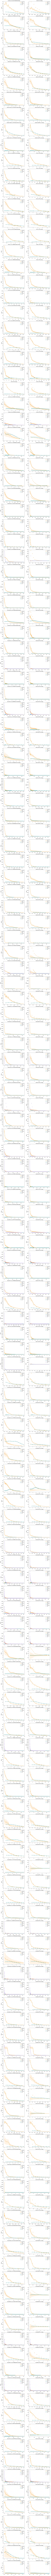

In [549]:
fig, axes = plt.subplots(len(profiles), 2, figsize=(15, 5*len(profiles)))
i = 0
for uid, prof in profiles.items():
    prof.plot(index=i, ax=axes[i][1])
    prof.auto_fit = False
    prof.plot(index=i, ax=axes[i][0])
    i += 1

In [234]:
good_examples = ['IC2574', 'NGC5985','DDO064', 'DDO161', 'F568-3']

In [235]:
points = 5000

simulations = {}
for i, uid in enumerate(good_examples):
    nbsetup.cp(i)
    prof = profiles[uid]
    
    space = Space((1,points,points), prof.max_r*4/points)
    masses, labels = prof.masses(space)
    
    sim = Galaxy(masses, space, mass_labels=labels)
    sim.profile = prof
    sim.name = uid
    sim.analyse(sim.radius_points(prof.max_r*1.5, 20))
    simulations[uid] = sim

nbsetup.cp("")

In [236]:
sparc_mass_ratio = {'gas': 1, 'disk': 1, 'bul': 1}

In [237]:
def plot_sparc(self, ax=None):
    
    for k in ('Vobs', 'Vgas', 'Vdisk', 'Vbul'):
        if k != 'Vbul' or self.profile.is_bul:
            sns.scatterplot(x=self.profile.rotmass_df['R'], y=self.profile.rotmass_df[k], label=k, ax=ax, color=COLOR_SCHEME[k[1:]])
    
    df = self.dataframe(mass_ratios=sparc_mass_ratio)
    
    for k in self.mass_labels:
        cdf = df.query("component=='%s'" % k)
        vel2 = (cdf['rd']*cdf['x_vec'])
        g = sns.lineplot(x=cdf['rd'], y=np.sign(vel2)*(np.abs(vel2)**0.5), ax=ax, label=k, color=COLOR_SCHEME[k])
        
    g.set(title=self.profile.sparc_dict['Vflat'])

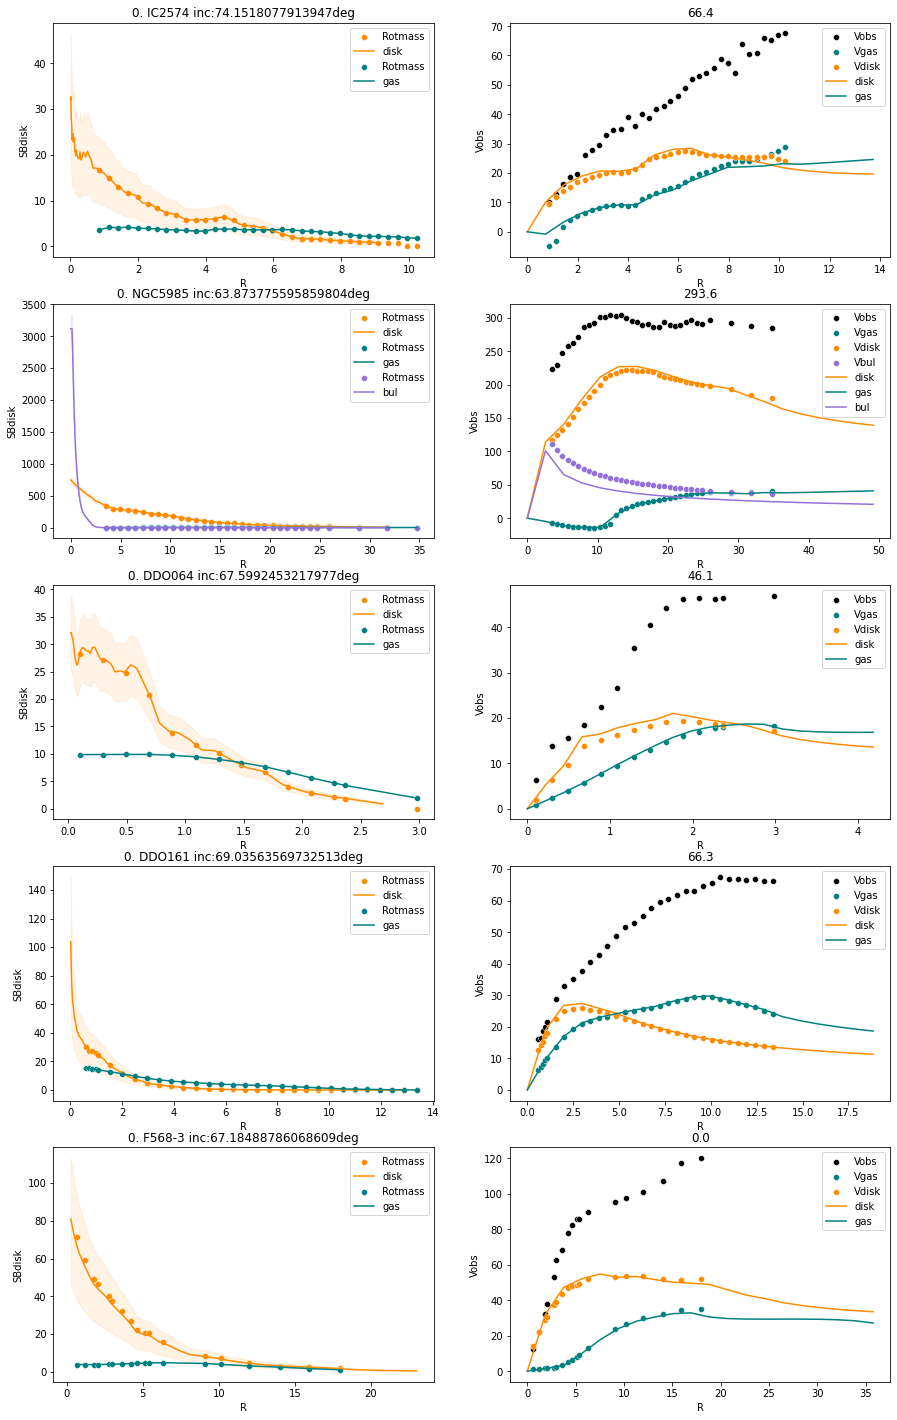

In [238]:
fig, axes = plt.subplots(len(simulations), 2, figsize=(15,5*len(simulations)))

for index, sim in enumerate(simulations.values()):
    sim.profile.plot(ax=axes[index][0])
    plot_sparc(sim, ax=axes[index][1])